У вас, с прошлого урока, имеются реализации расчёта среднеквадратичной ошибки и её градиента для линейнй регрессии с коэффициентами при факторах(w) и свободным коэффициентам.

class linear_regression:
    def _mserror(self, X, y_real):
        #рассчёт среднеквадратичной ошибки
        y = X.dot(self.w.T)+self.w0
        return np.sum((y - y_real)**2) / y_real.shape[0]
    def _mserror_grad(self, X, y_real):
        #рассчёт градиента ошибки.
        #2*delta.T.dot(X)/y_real.shape[0] - градиент по коэффициентам при факторах
        #np.sum(2*delta)/y_real.shape[0] - производная(градиент) при нулевом коэффициенте
        delta=(X.dot(self.w.T)+self.w0-y_real)
        return 2*delta.T.dot(X)/y_real.shape[0], np.sum(2*delta)/y_real.shape[0]
В этом задании вы должны модифицировать реализацию рассчёта среднеквадратичной ошибки и рассчёта её производной, так, чтобы с к среднеквадратичной ошибке добавлялась l2 регулярязационная поправка:  
 
 а к градиенту- ссответствующее выражение для градиента регулярязационной поправки.

На основе этих функций создайте свою регуляризированную полиномиальную регрессию и опробуйте на одном из примеров построения полиномиальной модели из этого урока.

In [301]:
import matplotlib
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as sklearn_LR
%matplotlib inline

In [302]:
n_features = 2
n_objects = 1000

X = np.random.uniform(-7, 7, (n_objects, n_features))

w_true = np.random.normal(size=(1, n_features ))

Y = X.dot(w_true.T) + np.random.normal(0, 0.5, size=(n_objects, 1))

In [303]:
w0 = np.zeros(shape=(1, n_features ))

In [304]:
def mserror(X, w, y_real):
    y = X.dot(w.T)
    return np.sum((y - y_real)**2) / y_real.shape[0]

In [305]:
mserror(X, w_true, Y), mserror(X, w_0, Y)

(0.27557784186748185, 107.05362368048809)

In [306]:
def mserror_grad(X, w, y_real):
    return 2*(X.dot(w.T)-y_real).T.dot(X)/y_real.shape[0]

In [307]:
mserror_grad(X, w_true, Y)

array([[-0.08719592,  0.01122846]])

In [308]:
mserror_grad(X, w0, Y)

array([[83.20285508, -0.35896337]])

In [309]:
w=w0

w_list = [w.copy().flatten()]

errors = []

eta = 0.02

max_iter = 1e4

min_weight_dist = 1e-8

weight_dist = np.inf

iter_num = 0

while weight_dist > min_weight_dist and iter_num < max_iter:
    new_w = w -  eta * mserror_grad(X, w, Y)
    weight_dist = np.linalg.norm(new_w - w)
    
    w_list.append(new_w.copy().flatten())
    cur_error=mserror(X, new_w, Y)
    print('curent error: {0}'.format(cur_error))
    errors.append(mserror(X, new_w, Y))
    
    iter_num += 1
    w = new_w
    
w_list = np.array(w_list)

curent error: 13.481001810668902
curent error: 1.9090086855758632
curent error: 0.47758085497898395
curent error: 0.30047376405104465
curent error: 0.27855525644475926
curent error: 0.2758419557006639
curent error: 0.2755059859007209
curent error: 0.2754643736339818
curent error: 0.27545921820459146
curent error: 0.27545857930267337
curent error: 0.2754585001012493
curent error: 0.27545849028004293
curent error: 0.2754584890618017
curent error: 0.27545848891063973
curent error: 0.2754584888918772
curent error: 0.2754584888895475
curent error: 0.27545848888925806
curent error: 0.27545848888922214
curent error: 0.2754584888892177
curent error: 0.27545848888921715


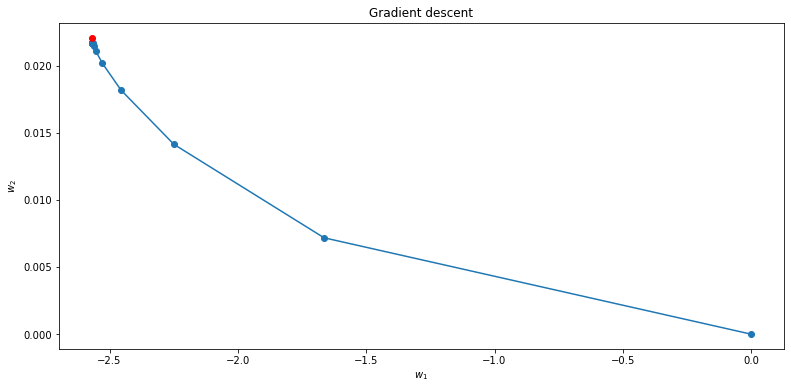

In [310]:
plt.figure(figsize=(13, 6))
plt.title('Gradient descent')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')

plt.scatter(w_list[:, 0], w_list[:, 1])
plt.scatter(w_true[0, 0], w_true[0, 1], c='r')
plt.plot(w_list[:, 0], w_list[:, 1])

plt.show()

Text(0, 0.5, 'MSE')

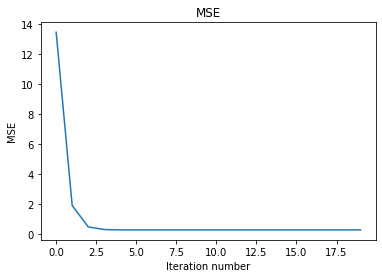

In [311]:
plt.plot(np.arange(len(errors)), errors)
plt.title('MSE')
plt.xlabel('Iteration number')
plt.ylabel('MSE')

Text(0, 0.5, 'log(MSE)')

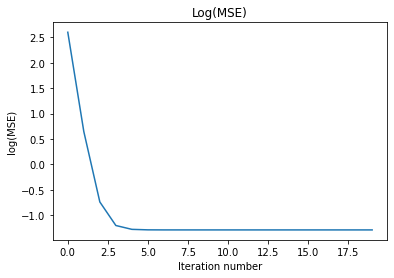

In [312]:
plt.plot(np.arange(len(errors)), np.log(np.array(errors)))
plt.title('Log(MSE)')
plt.xlabel('Iteration number')
plt.ylabel('log(MSE)')

In [313]:
def normal_equation(X, y):
    return np.linalg.solve((X.T).dot(X), (X.T).dot(y)).T

normal_eq_w = normal_equation(X, Y)
print('В случае использования нормального уравнения функционал ошибки составляет {0}'.format(
    round(mserror(X, normal_eq_w, Y), 4)))

В случае использования нормального уравнения функционал ошибки составляет 0.2755


In [314]:
class linear_regression:
    def __init__(self, eta = 0.9, max_iter = 1e4, min_weight_dist = 1e-8):
        self.eta = eta
        self.max_iter = max_iter
        self.min_weight_dist = min_weight_dist
    def _mserror(self, X, y_real):
        #рассчёт среднеквадратичной ошибки
        y = X.dot(self.w.T)+self.w0
        return np.sum((y - y_real)**2) / y_real.shape[0]
    def _mserror_grad(self, X, y_real):
        #рассчёт градиента ошибки.
        delta=(X.dot(self.w.T)+self.w0-y_real)
        2*delta.T.dot(X)/y_real.shape[0]
        np.sum(2*delta)/y_real.shape[0]
        return 2*delta.T.dot(X)/y_real.shape[0], 2*np.sum(delta)/y_real.shape[0]
    def _optimize(self, X, Y):
        #оптимизация коэффициентов
        iter_num = 0
        weight_dist = np.inf
        self.w = np.zeros((1, X.shape[1]))
        self.w0=0
        while weight_dist > self.min_weight_dist and iter_num < self.max_iter:
            gr_w, gr_w0=self._mserror_grad(X, Y)
            if iter_num==0:
                #Чтобы eta адаптировалась к порядку градиента, делим на l2 норму градиента в нуле
                eta=self.eta/np.sqrt(np.linalg.norm(gr_w)**2+(gr_w0)**2)
            new_w = self.w - eta * gr_w
            new_w0= self.w0 - eta * gr_w0
            weight_dist = np.sqrt(np.linalg.norm(new_w - self.w)**2+(new_w0 - self.w0)**2)
            iter_num += 1
            self.w = new_w
            self.w0 = new_w0
    def fit(self, X, Y):
        if Y.ndim==1:
            Y=Y[:, np.newaxis]
        self._optimize(X, Y)
        return self
    def predict(self, X):
        return (X.dot(self.w.T)+self.w0).flatten()
    def test(self, X, Y):
        if Y.ndim==1:
            Y=Y[:, np.newaxis]
        return self._mserror(X, Y)

In [315]:
shift=np.random.uniform(0, 100)
Y_shift=Y+shift
lr=linear_regression()
lr.fit(X, Y_shift)
lr.test(X, Y_shift)

0.27525640546825625

In [316]:
shift, lr.w0

(56.56003957377107, 56.574254444881646)

In [317]:
lr.w, w_true

(array([[-2.56660818,  0.02172245]]), array([[-2.56929217,  0.02208394]]))

In [318]:
def f(x):
    return (x**2)*(np.sin(0.5*x)**2+1)
np.random.seed(16)
x_data = np.random.uniform(-50, 50, size=(10,))
f_data = [f(i) for i in x_data] + np.random.uniform(-1000, 1000, size=(10,))
x_data = np.random.uniform(-50, 50, size=(10,))
f_data = [f(i) for i in x_data] + np.random.uniform(-1000, 1000, size=(10,))
dots = np.linspace(-50, 50, 100)

In [319]:
class polynomial_regression(linear_regression):
    def __init__(self, max_power, *args, **kwargs):
        self.max_power=max_power
        super().__init__(*args, **kwargs)
    @staticmethod
    def generate_features(x, max_power):
        x=x[:, np.newaxis]
        return np.concatenate([x**i for i in range(1, max_power+1)], axis=1)
    def fit(self, x, y):
        super().fit(self.generate_features(x, self.max_power), y)
    def predict(self, x):
        return super().predict(self.generate_features(x, self.max_power))
    def test(self, x, y):
        return super().test(self.generate_features(x, self.max_power), y)
    
class polynomial_regression_sklearn(sklearn_LR):
    def __init__(self, max_power, *args, **kwargs):
        self.max_power=max_power
        super().__init__(*args, **kwargs)
    generate_features=staticmethod(polynomial_regression.generate_features)
    def fit(self, x, y):
        super().fit(self.generate_features(x, self.max_power), y)
    def predict(self, x):
        return super().predict(self.generate_features(x, self.max_power))
    def test(self, x, y):
        return np.sum((self.predict(x) - y)**2) / y.shape[0]

In [320]:
polynomial_regression.generate_features(np.array([1, 2, 3, 4]), 4)

array([[  1,   1,   1,   1],
       [  2,   4,   8,  16],
       [  3,   9,  27,  81],
       [  4,  16,  64, 256]])

In [321]:
mod1=sklearn_LR()
mod1.fit(polynomial_regression.generate_features(x_data, 3), f_data)
mod1.predict(polynomial_regression.generate_features(x_data, 3))

array([1710.31635685, 3055.69890296, -252.03200063, -282.45290583,
        267.61122767, 2447.36989336,  797.1839177 , -287.80843082,
        944.12546908, 1196.66537918])

In [322]:
mod2=polynomial_regression_sklearn(3)
mod2.fit(x_data, f_data)
mod2.predict(x_data)

array([1710.31635685, 3055.69890296, -252.03200063, -282.45290583,
        267.61122767, 2447.36989336,  797.1839177 , -287.80843082,
        944.12546908, 1196.66537918])

In [323]:
our_mod=polynomial_regression(2)
our_mod.fit(x_data, f_data)
sk_mod=polynomial_regression_sklearn(2)
sk_mod.fit(x_data, f_data)
print('Коэффициенты при факторах(наша модель):', our_mod.w)
print('Коэффициенты при факторах(sklearn):', sk_mod.coef_)
print('Нулевые коэффициенты(интерцепты):',our_mod.w0, sk_mod.intercept_)

Коэффициенты при факторах(наша модель): [[7.02515899 1.36741048]]
Коэффициенты при факторах(sklearn): [8.97929924 1.6010308 ]
Нулевые коэффициенты(интерцепты): -0.7747582320779166 -327.4719776212555


In [324]:
our_mod.predict(x_data)

array([1698.30556543, 2678.27464822,  106.27758393,   -9.72592152,
        339.14765423, 2531.45456477, 1048.00112463,   55.22323094,
       1163.13500132, 1356.82424313])

In [325]:
sk_mod.predict(x_data)

array([1633.31204043, 2840.77902255, -197.12048626, -340.06190193,
         56.54588609, 2602.94844841,  919.517756  , -258.64474715,
       1055.43377212, 1283.96801924])

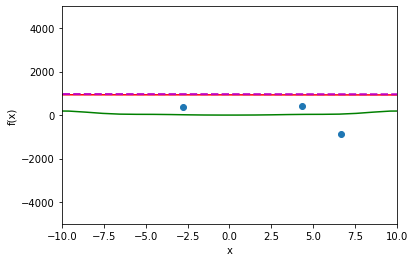

In [326]:
#Актуальные данные
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

#Наша модель
model1 = polynomial_regression(1)
model1.fit(x_data, f_data)
plt.plot(dots, model1.predict(dots), color='r')

#Sklearn
model2 = polynomial_regression_sklearn(1)
model2.fit(x_data, f_data)
plt.plot(dots, model2.predict(dots), 'm--', linewidth=2)

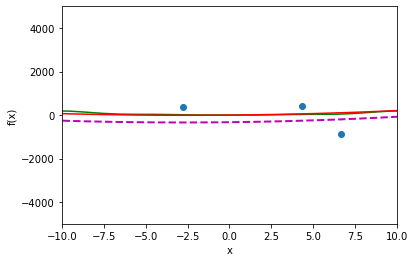

In [327]:
#Актуальные данные
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

#Наша модель
model1 = polynomial_regression(2)
model1.fit(x_data, f_data)
plt.plot(dots, model1.predict(dots), color='r')

#Sklearn
model2 = polynomial_regression_sklearn(2)
model2.fit(x_data, f_data)
plt.plot(dots, model2.predict(dots), 'm--', linewidth=2)

<ipython-input-314-6af9112e1171>:29: RuntimeWarning: overflow encountered in double_scalars
  weight_dist = np.sqrt(np.linalg.norm(new_w - self.w)**2+(new_w0 - self.w0)**2)


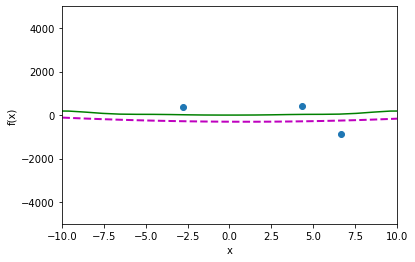

In [328]:
#Актуальные данные
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

#Наша модель
model1 = polynomial_regression(3)
model1.fit(x_data, f_data)
plt.plot(dots, model1.predict(dots), color='r')

#Sklearn
model2 = polynomial_regression_sklearn(3)
model2.fit(x_data, f_data)
plt.plot(dots, model2.predict(dots), 'm--', linewidth=2)

<ipython-input-314-6af9112e1171>:29: RuntimeWarning: overflow encountered in double_scalars
  weight_dist = np.sqrt(np.linalg.norm(new_w - self.w)**2+(new_w0 - self.w0)**2)
<ipython-input-314-6af9112e1171>:13: RuntimeWarning: overflow encountered in multiply
  2*delta.T.dot(X)/y_real.shape[0]
<ipython-input-314-6af9112e1171>:15: RuntimeWarning: overflow encountered in multiply
  return 2*delta.T.dot(X)/y_real.shape[0], 2*np.sum(delta)/y_real.shape[0]
<ipython-input-314-6af9112e1171>:27: RuntimeWarning: invalid value encountered in subtract
  new_w = self.w - eta * gr_w


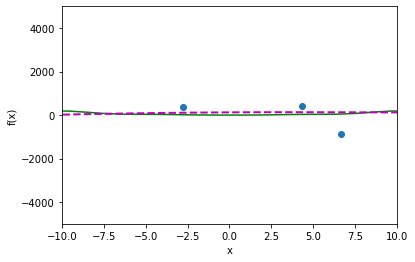

In [329]:
#Актуальные данные
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

#Наша модель
model1 = polynomial_regression(4, 0.01)
model1.fit(x_data, f_data)
plt.plot(dots, model1.predict(dots), color='r')

#Sklearn
model2 = polynomial_regression_sklearn(4)
model2.fit(x_data, f_data)
plt.plot(dots, model2.predict(dots), 'm--', linewidth=2)

<ipython-input-314-6af9112e1171>:29: RuntimeWarning: overflow encountered in double_scalars
  weight_dist = np.sqrt(np.linalg.norm(new_w - self.w)**2+(new_w0 - self.w0)**2)
<ipython-input-314-6af9112e1171>:27: RuntimeWarning: invalid value encountered in subtract
  new_w = self.w - eta * gr_w


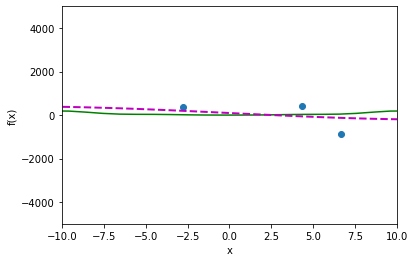

In [330]:
#Актуальные данные
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

#Наша модель
model1 = polynomial_regression(6, 0.0005, max_iter = 1e5)
model1.fit(x_data, f_data)
plt.plot(dots, model1.predict(dots), color='r')

#Sklearn
model2 = polynomial_regression_sklearn(6)
model2.fit(x_data, f_data)
plt.plot(dots, model2.predict(dots), 'm--', linewidth=2)

In [331]:
model1.test(x_data, f_data), model2.test(x_data, f_data)

(nan, 115789.67596093503)

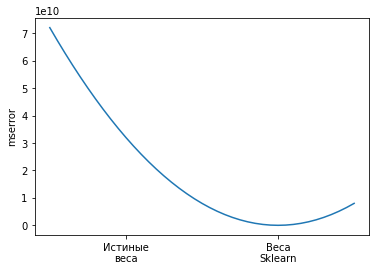

In [332]:
#Истиные коэффициенты используемые для генерации данных
w_true=np.array([[- 13.2,  - 5.3,  - 4.17, 0, 0, 0]])
w0_true=0.6

#Коэффициенты из Sklearn
w_sklearn=model2.coef_[np.newaxis, :]
w0_sklearn=model2.intercept_

x=polynomial_regression.generate_features(x_data, 6)
y=f_data[:, np.newaxis]
n_samples=len(f_data)

x_dots=np.arange(-0.5, 1.55, 0.05)
def _mserror(w, w0):
    diff=x.dot(w.T)+w0-y
    return np.sum(diff**2)/n_samples

mserror_values=np.array([_mserror(w_true+(w_sklearn-w_true)*i, w0_true+(w0_sklearn-w0_true)*i) 
                         for i in x_dots])
#Актуальные данные
plt.ylabel('mserror')
plt.xticks([0, 1], ['Истиные\nвеса', 'Веса\nSklearn'])
plt.plot(x_dots, mserror_values)

In [333]:
from scipy.optimize import minimize
class polynomial_regression_lbfgs(polynomial_regression):
    def __init__(self, max_power):
        self.max_power=max_power
    def _optimize(self, X, Y):
        def assign_w(w):
            self.w0=w[0]
            self.w=w[1:][np.newaxis, :]
        def func(w):
            assign_w(w)
            #print(self.w0, self.w)
            #print('scipy', w)
            return super(polynomial_regression, self).test(X, Y)
        def jac(w):
            assign_w(w)
            gr_w, gr_w0=self._mserror_grad(X, Y)
            return np.concatenate([[gr_w0], gr_w.flatten()])
        w=np.zeros((X.shape[1]+1,))
        w=minimize(func, w, jac=jac, method='BFGS').x
        assign_w(w)

In [334]:
model_bfgs=polynomial_regression_lbfgs(6)
model_bfgs.fit(x_data, f_data)
model_bfgs.test(x_data, f_data)

115789.67596093504

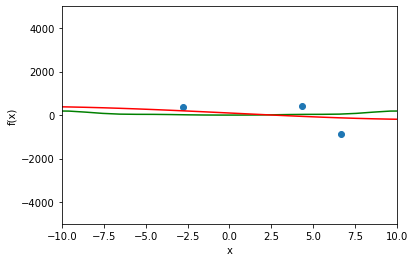

In [335]:
#Актуальные данные
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

#Наша модель
plt.plot(dots, model_bfgs.predict(dots), color='r')